In [1]:
import sympy
from sympy.parsing.sympy_parser import (parse_expr, standard_transformations,
                                        implicit_multiplication_application,convert_xor)
from IPython.display import display
sympy.init_printing(use_latex='mathjax')
import numpy as np
np.set_printoptions(suppress=True)
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, generate_preset_pass_manager, transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from sympy.functions.special.polynomials import chebyshevt
from scipy.stats import beta
from qiskit.circuit.library import PolynomialPauliRotationsGate
from qiskit.visualization import plot_histogram

service = QiskitRuntimeService(name="qiskit_adi")
# Get a backend
backend = AerSimulator()
#backend = service.least_busy(operational=True, simulator=False)
#backend= service.backend(name='ibm_torino')
print(f"We are using the {backend.name} quantum computer")
sampler = Sampler(mode=backend)

# Submit the circuit to Sampler
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

We are using the aer_simulator quantum computer


In [2]:
try:
    # Input
    func_str = input("Enter the function to integrate (e.g., sin(x) * exp(-x)): ")
    lower_limit_str = input("Enter the lower limit of integration (e.g., 0): ")
    upper_limit_str = input("Enter the upper limit of integration (e.g., pi): ")

    # Define the symbols
    x = sympy.symbols('x', real=True)
    expected_symbols = {x}

    # Parse the Function String
    local_dict = {'x': x}
    global_dict = sympy.__dict__
    transformations = standard_transformations + (implicit_multiplication_application, convert_xor)
    func_expr = parse_expr(func_str,
                           local_dict=local_dict,
                           global_dict=global_dict,
                           transformations=transformations)

    # VALIDATE
    found_symbols = func_expr.free_symbols
    if not found_symbols.issubset(expected_symbols):
        unknown_symbols = found_symbols - expected_symbols
        raise ValueError(f"Function contains unknown variables: {unknown_symbols}. "
                         f"The expression must only depend on 'x'.")

    # --- Finalize Inputs ---
    lower_limit = sympy.sympify(lower_limit_str)
    upper_limit = sympy.sympify(upper_limit_str)

    func = sympy.simplify(func_expr)
    
    # --- Display the problem ---
    integral_expr = sympy.Integral(func, (x, lower_limit, upper_limit))
    print("\nEntered definite integral Mathematical expression:")
    display(integral_expr)

    # Convert limits to floats to prevent constants parsing errors
    try:
        lower_limit_f = float(lower_limit)
        upper_limit_f = float(upper_limit)
    except TypeError:
        lower_limit_f = float(lower_limit.evalf())
        upper_limit_f = float(upper_limit.evalf())

    lower_limit=lower_limit_f
    upper_limit= upper_limit_f
except Exception as e:
    print(f"\nError: Could not process the input. Please check the expression. \nDetails: {e}")






Entered definite integral Mathematical expression:


10          
⌠           
⎮  log(x) dx
⌡           
1           

In [3]:
def getChebyshevPolynomial( sympy_symbol,sympy_func ,degree, lower_limit, upper_limit):
    """
    Generates a high-quality Chebyshev polynomial approximation for a given SymPy function
    using NumPy's fitting method.
    This is the ideal method because Taylor's approximation requires O(d^2) oracle calls.
    Chebyshev approximation also uniformly distributes the error in the range making it ideal for this scenario.
    """
    print(f"Chebyshev Approximation to {degree}th degree:\n")

    # 1. Callable numerical version of the function "Oracle"
    f_numeric = sympy.lambdify(sympy_symbol, sympy_func, 'numpy')

    # 2. Define the coordinate transformation from [lower_limit, upper_limit] to [-1, 1]
    jac_scaling = (upper_limit - lower_limit) / 2.0
    offset = (upper_limit + lower_limit) / 2.0
    
    # This is f(x) re-parameterized in terms of y. This is the function we will approximate.
    func_to_approximate = lambda y_val: f_numeric(jac_scaling * y_val + offset)

    # 3. Generate sample points and query the oracle to get data for fitting
    # For a degree `d` polynomial, we need at least `d+1` points. 2*degree is ideal
    num_samples = 2 * degree
    sample_points_y = np.linspace(-1, 1, num_samples)
    sample_values_f = func_to_approximate(sample_points_y)

    # 4. Use NumPy to fit the Chebyshev polynomial to the sampled data
    cheb_poly_fit = np.polynomial.chebyshev.Chebyshev.fit(
        sample_points_y,
        sample_values_f,
        deg=degree
    )
    
    # The coefficients are ordered from T_0 to T_d
    coeffs = cheb_poly_fit.convert().coef
    print(f"Found {len(coeffs)} coefficients.")

    # 5. Calculate the scaling factor M = max(|f(x)|)
    # We find the max value by evaluating our new high-quality approximation on a fine grid.
    fine_grid_y = np.linspace(-1, 1, 1000)
    max_f_val = np.max(np.abs(cheb_poly_fit(fine_grid_y)))
    M =  max_f_val
    print(f"M value for scaling is: {M:.4f}")

    # 6. Reconstruct a SymPy expression for display and symbolic integration
    # The polynomial for the integral must approximate g(y) = f(x) * jac_scaling
    y_sym = sympy.Symbol('y')
    chebyshev_sympy_f = sum(coeffs[i] * chebyshevt(i, y_sym) for i in range(len(coeffs)))
    chebyshev_sympy_g = jac_scaling * chebyshev_sympy_f

    integration_expr = sympy.Integral(chebyshev_sympy_g, (y_sym, -1, 1))
    print("\nApproximated Integral (Chebyshev Polynomial on [-1, 1]):")
    display(integration_expr)
    
    # 7. New: Explicitly check the endpoint error to verify the quality
    true_val_at_endpoint = func_to_approximate(1.0) # This is f(upper_limit)
    approx_val_at_endpoint = cheb_poly_fit(1.0)
    abs_error = np.abs(true_val_at_endpoint - approx_val_at_endpoint)
    
    print(f"\nError analysis at endpoint y=1 (x={upper_limit}):")
    print(f"  - True value of f({upper_limit}) = {true_val_at_endpoint:.8f}")
    print(f"  - Approx value from poly = {approx_val_at_endpoint:.8f}")
    print(f"  - Absolute Error = {abs_error:.2e}")

    return coeffs, M, chebyshev_sympy_g

In [4]:
# Discretize func_expr
def discretize(f_callable,lower_limit, upper_limit,N):
    upper_limit= float(upper_limit)
    lower_limit= float(lower_limit)
    
    #f_callable= sympy.lambdify(x, func, 'numpy')

    # N random X points such that there are N random F(x). Sigma F(x) deltaX is integral (RIEMANN SUM)
    x_array = np.random.uniform(lower_limit,upper_limit,N)
    y_array= f_callable(x_array)
   
    return y_array,x_array 

In [7]:
# Degree of Approximation
d= 10
num_qubits=9
N=2**num_qubits

In [8]:
# Plot an unscaled approximated polyomial to show that the approximated graph is very close to the original.
# Also Plot the |f(x)-P(x)| graph to show that the error is uniformly distributed.
### NOTE: Here g(y) is returned. g(y)= f(x)* jac_scaling.  f(x)= g(y)/jac_scaling..
#  jac_scaling=(upper-lower)/2
chebyshev_coeffs, M,chebyshev_Polynomial= getChebyshevPolynomial(x,func, d, lower_limit, upper_limit)
#The coefffs returned here are unscaled coeffs. Coeffs to load= chebyshev_coeffs/M

Chebyshev Approximation to 10th degree:

Found 11 coefficients.
M value for scaling is: 2.3026

Approximated Integral (Chebyshev Polynomial on [-1, 1]):


1                                                                              ↪
⌠                                                                              ↪
⎮  ⎛                     10                      9                      8      ↪
⎮  ⎝- 0.547869378971607⋅y   + 0.624680015052126⋅y  + 0.618717733787598⋅y  - 0. ↪
⌡                                                                              ↪
-1                                                                             ↪

↪                                                                              ↪
↪                                                                              ↪
↪                  7                      6                      5             ↪
↪ 568651498576558⋅y  - 0.641625747383576⋅y  + 0.682565259073614⋅y  - 0.4055646 ↪
↪                                                                              ↪
↪                                                                              ↪

↪                         


Error analysis at endpoint y=1 (x=10.0):
  - True value of f(10.0) = 2.30258509
  - Approx value from poly = 2.30257841
  - Absolute Error = 6.68e-06


In [9]:
# Create a numerical version of the original function f(x).
f_numerical = sympy.lambdify(x, func, 'numpy')
jac_scaling = (upper_limit - lower_limit) / 2.0
offset = (upper_limit + lower_limit) / 2.0
f_ideal_callable = lambda y: f_numerical(jac_scaling * y + offset)

y,x_array= discretize(f_ideal_callable,-1,1,N)


g_numerical = sympy.lambdify(sympy.symbols('y',real=True),
                              chebyshev_Polynomial, 'numpy')

# gy_classical= f(x)/jac_scaling
jac_scaling = (upper_limit - lower_limit) / 2.0
y_classical= g_numerical(x_array)/jac_scaling

In [10]:
def IntegrateClassical(y_classical,lower_limit,upper_limit,N):

    total_sum= np.sum(y_classical)

    # Average
    answer=(total_sum/N)*((upper_limit-lower_limit))

    print("Y Classical Array:")
    print(y_classical)


    print("\nClassical Integration Answer:")
    print(answer)
    return

IntegrateClassical(y_classical,lower_limit,upper_limit,N)


Y Classical Array:
[2.2659269  0.91208847 1.51339986 1.57714197 1.87204703 1.28404209
 2.2758542  1.9538663  1.89509317 0.86392379 0.44101378 0.00491498
 1.85358865 1.23717118 1.28818518 0.83973224 0.49031281 1.48285001
 1.95921316 0.27731355 1.04555078 2.15180782 1.84721499 1.62077532
 2.29433921 1.55885806 2.23260639 2.25370988 1.96820791 1.96432766
 2.15266444 0.07446871 0.87470277 1.81176346 0.24042484 2.13040633
 2.1516847  2.08244067 2.0612862  1.35814719 2.25802528 2.08400879
 1.99159277 1.42589724 1.1267506  0.32968419 1.5386055  1.0995623
 0.72788617 1.13715091 1.62006153 0.0615914  2.17602063 2.27884228
 2.08904174 2.30255917 0.57400916 1.86610965 0.60690859 1.85065856
 1.39604611 1.44318165 1.65805369 1.16131581 2.14468004 1.51551856
 0.58050829 1.02486398 2.20414712 1.37622141 2.04610898 1.95553125
 2.042012   0.98886766 1.74878302 0.93326785 2.16899284 2.24926281
 1.63555043 1.44426841 0.95903257 0.23546715 1.7600464  0.80056214
 1.56509291 1.96070427 1.87535658 1.89807615

The Original Function F_callable is assumed to be the ideal in N samples to show almost continuous function plot.

Chebyshev_polynomial_expr is the approximated chebyshev polynomial from the original f(x)
    This polynomial is approximated to the dth degree and N= 2**n samples.
    The plots of this polynomial are in Green Color.


Quantum Loaded Plots are in Blue Color.
 


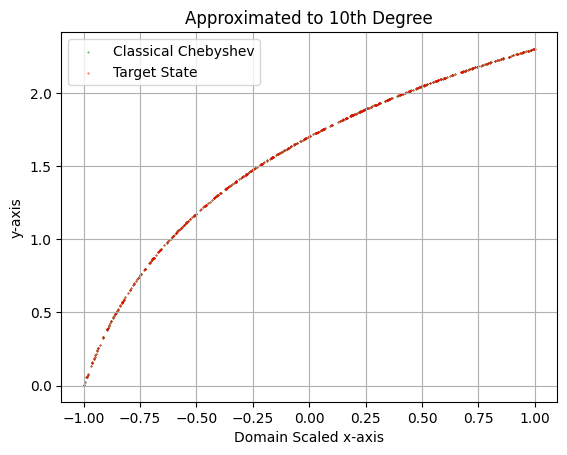

In [11]:
plt.xlabel("Domain Scaled x-axis")
plt.ylabel("y-axis")
plt.title(f"Approximated to {d}th Degree")
plt.scatter(x_array,y_classical,
             color='green', label='Classical Chebyshev',s=0.1)
plt.scatter(x_array,y,
            color='red',label='Target State', s=0.1)
plt.grid(True)
plt.legend()
plt.show()

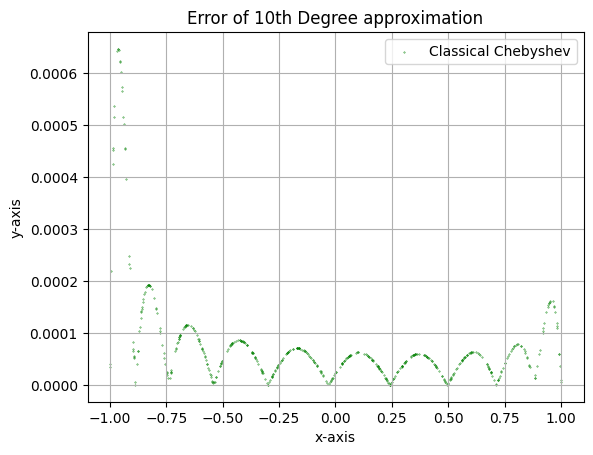

In [12]:
plt.xlabel("x-axis")
plt.ylabel("y-axis")

plt.title(f"Error of {d}th Degree approximation")
plt.scatter(x_array,np.abs(y_classical-y),
             color='green', label='Classical Chebyshev',s=0.1)
plt.grid(True)
plt.legend()
plt.show()

In [13]:
print(f"The Chebyshev polynomial {len(chebyshev_coeffs)} coefficients to encode on Quantum Circuit are: ")
chebyshev_coeffs/=M
print(chebyshev_coeffs)

The Chebyshev polynomial 11 coefficients to encode on Quantum Circuit are: 
[ 0.63658844  0.45127724 -0.11723282  0.04063056 -0.01583373  0.00659258
 -0.00285029  0.00126199 -0.00056621  0.0002355  -0.00010327]


In [14]:
def FindNextK(ki,ThetaL, ThetaU, upI, r=2):
    Ki= 4*ki+2 # current θ-factor
    ThetaI_min= Ki*ThetaL # lower bound for scaled θ
    ThetaI_max= Ki*ThetaU # upper bound for scaled θ

    # set an upper bound for θ-factor
    K_max= np.floor((np.pi)/(ThetaU-ThetaL))

    # largest potential candidate of the form 4k + 2
    K= K_max- np.mod(K_max-2,4)


    while K>=r*Ki:
        q= K/Ki # factor to scale [θmini , θmaxi ]
        if np.mod(q*ThetaI_max,2*np.pi)<=np.pi and np.mod(q*ThetaI_min,2*np.pi)<=np.pi :
            # [θmini+1, θmaxi+1] is in upper half-plane 
            Ki1= K
            upI1= True
            ki1= (Ki1-2)/4
            return ki1,upI1
        
        elif np.mod(q*ThetaI_max,2*np.pi)>=np.pi and np.mod(q*ThetaI_min,2*np.pi)>=np.pi :
            # [θmini+1, θmaxi+1] is in lower half-plane
            Ki1= K
            upI1= False
            ki1= (Ki1-2)/4
            return ki1, upI1
        K-=4
    return ki,upI # return old value
   

In [15]:
def AppendOperatorQ(num_qubits,qc,Qbit,polyOracle,inverted_polyOracle):
    """Appends the Q operator circuit from the A oracle."""


    # Spsi0 is just flipping the last Ancilla qubit Phase. As there are n qubits + 1 Ancilla qubit
    #  Just XZX gate to last n+1th qubit will do the job
    #  |psi0>|0>+ |psi1>|1>  ----->  -|psi0>|0> + |psi1||1>
    qc.x(Qbit[num_qubits])
    qc.z(Qbit[num_qubits])
    qc.x(Qbit[num_qubits])
    qc.barrier(Qbit)
    #For now loader and loaderInverse are just H gates. 
    # A^-1 oracle
    qc.append(inverted_polyOracle,Qbit)
    for i in range(num_qubits):
        qc.h(Qbit[i])
        
    qc.barrier(Qbit)
    # S0 is basically  I-2|0 x 0| because we are kicking back |0> in kickback
    # Basically an OR gate kickback. so |00...0> is kicked back. Everything else remains the same

    # This flips the phase of the state where all qubits in Qbit are 0.
    # Flip all qubits from |0> to |1> with X-gates
    qc.x(Qbit)

    # Apply a multi-controlled Z gate (mcz).
    # mcp(np.pi, ...) is equivalent to mcz.
    # This flips the phase of the |11...1> state.
    control_qubits = Qbit[:-1]  # All qubits except the last one
    target_qubit = Qbit[-1]     # The last qubit
    qc.mcp(np.pi, control_qubits, target_qubit)

    # Flip all qubits back with X-gates
    qc.x(Qbit)
    qc.barrier(Qbit)
    
    # A
    for i in range(num_qubits):
        qc.h(Qbit[i])
    qc.append(polyOracle,Qbit)
    qc.barrier(Qbit)

    return qc

In [16]:

polyOracle = PolynomialPauliRotationsGate(
    num_state_qubits=num_qubits,
    coeffs=chebyshev_coeffs.tolist(),
    basis='Y',label='A_P(x)'
)


inverted_polyOracle=polyOracle.inverse()

#polyOracle= polyOracle.decompositions


In [17]:
def runCircuit(ki,N, num_qubits,polyOracle,inverted_polyOracle):
    
    Qbit= QuantumRegister(num_qubits+1,name='logical')
    C_anc= ClassicalRegister(1,name='F_anc')
    qc= QuantumCircuit(Qbit,C_anc)

    for i in range(num_qubits):
        qc.h(Qbit[i])

    qc.append(polyOracle,Qbit)
    qc.barrier(Qbit)        

    for _ in range(ki):
        qc= AppendOperatorQ(num_qubits,qc, Qbit,polyOracle,inverted_polyOracle)

    qc.measure(Qbit[num_qubits],C_anc)

    transpiled_qc= transpile(qc)
    job = sampler.run(pm.run([transpiled_qc]),shots=N)

    # Get the results
    results = job.result()[0].data

    counts= results.F_anc.get_counts()

    #  Qiskit bitstrings are ordered from the end
    #  Last Bit is the first index
    num_1=0
    for key,value in counts.items():
        if key[0]== '1':
            num_1+=value
    
    prob_1= num_1/N

    return prob_1, num_1, N

In [ ]:

def ClopperPearsonInterval(counts, shots, alpha):
    """
    Calculates the Clopper-Pearson confidence interval for a binomial proportion.
    """
    # alpha is the total error prob; for a two-sided interval, use alpha/2
    lower = beta.ppf(alpha / 2, counts, shots - counts + 1) if counts > 0 else 0
    upper = beta.ppf(1 - alpha / 2, counts + 1, shots - counts) if counts < shots else 1
    return lower, upper


def IQAE(epsilon, alpha, N_shots, num_qubits, polyOracle, inverted_polyOracle):
    # --- Initialization ---
    i = 0
    ki = 0
    UPi = True
    ThetaL = 0
    ThetaU = np.pi / 2
    
    # This dictionary will store the results for each k
    results_log = {}  # Format: {k: (total_successes, total_shots)}

    # Correct alpha for the number of rounds using the union bound
    T = np.ceil(np.log2(np.pi / (8 * epsilon)))
    alpha_prime = alpha / T
    
    # For simplicity, we'll omit the Lmax and no-overshooting for now
    
    # --- Main Loop ---
    while ThetaU - ThetaL > 2 * epsilon:
        i += 1

        # Store the k from the previous iteration to check for changes
        ki_prev = ki

        # 1. Find the next power k, passing the CURRENT k and up state
        ki, UPi = FindNextK(ki, ThetaL, ThetaU, UPi)
        Ki = 4 * ki + 2
        
        # For now, we use a fixed number of shots in each run
        N = N_shots

        # 2. Run the circuit and get the raw counts and shots
        # We only need num_1 and N from the return values here
        _, num_1, shots = runCircuit(ki, N, num_qubits, polyOracle, inverted_polyOracle)
        
        # 3. Combine results if k has not changed
        if ki == ki_prev:
            # Add the new results to the old ones
            prev_counts, prev_shots = results_log.get(ki, (0, 0))
            total_counts = prev_counts + num_1
            total_shots = prev_shots + shots
            results_log[ki] = (total_counts, total_shots)
        else:
            # This is a new k, so we start fresh
            results_log[ki] = (num_1, shots)
            
        # Get the final combined results for this k
        final_counts, final_shots = results_log[ki]

        # 4. Calculate the confidence interval for the probability a_i
        ai_min, ai_max = ClopperPearsonInterval(final_counts, final_shots, alpha_prime)

        # 5. Invert the probability interval to get an angle interval for the magnified angle
        if UPi: # Upper half-plane
            # Note the swapped order because arccos is a decreasing function
            theta_i_min = np.arccos(1 - 2 * ai_max)
            theta_i_max = np.arccos(1 - 2 * ai_min)
        else: # Lower half-plane
            theta_i_min = 2 * np.pi - np.arccos(1 - 2 * ai_min)
            theta_i_max = 2 * np.pi - np.arccos(1 - 2 * ai_max)

        # 6. Update the main confidence interval [ThetaL, ThetaU]
        # This is the "un-magnify" step
        # Find the integer j offset for the wrap-around
        j = np.floor(Ki * ThetaL / (2 * np.pi))
        
        # Calculate the new interval candidate
        theta_l_new = (2 * np.pi * j + theta_i_min) / Ki
        theta_u_new = (2 * np.pi * j + theta_i_max) / Ki
        
        # The new interval is the intersection of the old knowledge and the new measurement
        ThetaL = max(ThetaL, theta_l_new)
        ThetaU = min(ThetaU, theta_u_new)

    # --- Return Final Results ---
    a_l = np.sin(ThetaL)**2
    a_u = np.sin(ThetaU)**2
    
    return [a_l, a_u]
        

        


In [19]:
if __name__ == '__main__':
    # --- 4. Set IQAE Parameters and Run ---
    epsilon_target = 0.01
    alpha_confidence = 0.05
    shots_per_run = 1024
    print("Starting Iterative Amplitude Estimation...")
    
    final_interval = IQAE(epsilon_target,alpha_confidence,shots_per_run,num_qubits
                          ,polyOracle,inverted_polyOracle)
    
    print("\n--- IQAE Complete ---")
    print(f"Final estimate interval: {final_interval}")
    

Starting Iterative Amplitude Estimation...

--- IQAE Complete ---
Final estimate interval: [np.float64(0.5309299368654015), np.float64(0.4476914985808271)]
